## Import libraries

In [43]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from lenet5 import LeNet
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

# from lenet5 import LeNet



## Set Parameters

In [44]:
# Check if cuda is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Training Parameters
LEARNING_RATE = 2e-3  # LR
BATCH_SIZE = 32
ROUNDS = 100  # R
LOCAL_EPOCHS = 1  # E
NUM_CLIENTS = 100  # K: number of total clients
C = 0.3  # percentage of clients selected at each round
# m = C * K : number of  clients selected at each round
NUM_SELECTED = max(int(C * NUM_CLIENTS), 1)

# Save plots in the folder ./plots or show them
SAVE_PLOTS = False

# If the clients have different numbers of images or not
DIFFERENT_SIZES = True 

# Use batch normalization or not
# Use batch normalization or not
BATCH_NORM = False 
# group normalization
GROUP_NORM = False 

# group normalization parameters
groupNormParams= {
'groupNL1' : 2,
'groupNL2' :2
}


if GROUP_NORM ==True & BATCH_NORM ==True:
    print(" Cannot have group an batch normalization True at the same time")
    exit()

## Training and Validation functions

In [45]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_target in train_loader:

        # set gradient to zero
        optimizer.zero_grad()

        # If there is a GPU, pass the data to GPU
        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction

        # Call model forward()
        y_predict, _ = model(X)

        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

        # Adjusting weights
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def test(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_target in valid_loader:

        # If there is a GPU, pass the data to the GPU
        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction and loss

        # Call model forward()
        y_predict, _ = model(X)

        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss


def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def client_update(model, optimizer, train_loader, device, criterion, epochs):
    """
    This function updates/trains client model on client data
    """
    for e in range(epochs):
        model, optimizer, train_loss = train(train_loader, model,
                                             criterion, optimizer, device)
    return train_loss


def server_aggregate(global_model, client_models, client_idx, lengths):
    """
    This function has aggregation method 'mean'
    """
    # This will take simple mean of the weights of models

    totLength= float(sum(lengths))
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        globDict = 0
        for i in range(len(lengths)):
            globDict += client_models[client_idx[i]].state_dict()[k].float() * float(lengths[i]) / totLength
        global_dict[k] =globDict
            

    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict())


In [46]:
def training_loop(centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader,
                  rounds, epochs, num_clients, num_selected, device, print_every=1):

    avg_train_losses = []  # weighted average train losses between clients
    avg_train_accuracies = []  # weighted average train accuracies between clients

    valid_losses = []   
    valid_accuracies = []

    # Train model
    for round in range(rounds):

        # Select random clients
        # Select in the total number of clients, a random array of clients of size num_selected at each round
        client_idx = np.random.permutation(num_clients)[:num_selected]

        local_train_losses = []  # Local train losses of the clients in this round
        local_train_accuracies = []  # Local train accuracies of the clients in this round
        # Local validation accuracies of the clients in this round

        local_len = []
        tot_images = 0

        for i in range(num_selected):
            # Train federated model locally in client i for num_epochs epochs
            # FIX: local_train_loss = client_update(federatedModels[i], optimizers[i], train_loader[client_idx[i]], device, criterion, epochs)
            # FIX: local_train_acc = get_accuracy(federatedModels[i], train_loader[client_idx[i]], device)
            local_train_loss = client_update(federatedModels[client_idx[i]], optimizers[client_idx[i]], train_loader[client_idx[i]], device, criterion, epochs)
            local_train_acc = get_accuracy(federatedModels[client_idx[i]], train_loader[client_idx[i]], device)

            lenDataLoad = len(train_loader[client_idx[i]]) # number of images seen by that client
            tot_images += lenDataLoad
            local_len.append(lenDataLoad) # gets the number of images per data loader

            local_train_losses.append(local_train_loss * lenDataLoad) # Add the local loss for this client weighted with the number of images seen
            local_train_accuracies.append(local_train_acc * lenDataLoad)

        server_aggregate(centralizedModel, federatedModels, client_idx, local_len)

        # Calculate avg training loss over all selected users at each round
        avg_train_loss= sum(local_train_losses) / tot_images 
        avg_train_losses.append(avg_train_loss)

        # Calculate avg training accuracy over all selected users at each round
        avg_train_acc = sum(local_train_accuracies) / tot_images 
        avg_train_accuracies.append(avg_train_acc)

        # Validation

        # Disable gradient calculation to save memory
        with torch.no_grad():
            model, valid_loss = test(test_loader, centralizedModel, criterion, device)
            valid_losses.append(valid_loss)

            valid_acc = get_accuracy(centralizedModel, test_loader, device)
            valid_accuracies.append(valid_acc)



        print(f'Round: {round}\t'
              f'Train loss: {avg_train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Train accuracy: {100 * avg_train_acc:.2f}\t'
              f'Valid accuracy: {100 * valid_acc:.2f}')
    return centralizedModel, federatedModels, optimizers, (avg_train_losses, valid_losses), (avg_train_accuracies, valid_accuracies)


## Loaders and Transformations

In [47]:
# Image augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Loading CIFAR10 using torchvision.datasets
traindata = datasets.CIFAR10('./data', train=True, download=False,
                             transform=transform_train)


total_data = traindata.data.shape[0] # number of data
if DIFFERENT_SIZES:
    # Dividing the training data into num_clients, with each clients having different number of images
    delta = 100 # controls how much the images numbers can vary from client to client
    min_val = max(int(total_data/ NUM_CLIENTS) - delta, 1) # min value of number of images for each client
    max_val = min(int(total_data/ NUM_CLIENTS) + delta, total_data - 1) # max value of number of images for each client

    indices = list(range(NUM_CLIENTS)) # list of indices for the splits of the data
    lengths = [random.randint(min_val,max_val) for i in indices] # List of lengths of splits to be produced

    diff = sum(lengths) - total_data # we are off by this abount 

    # Iterate through, incrementing/decrementing a random index 
    while diff != 0:  
        addthis = 1 if diff > 0 else -1 # +/- 1 depending on if we were above or below target.
        diff -= addthis

        idx = random.choice(indices) # Pick a random index to modify, check if it's OK to modify
        while not (min_val < (lengths[idx] - addthis) < max_val): 
            idx = random.choice(indices) # Not OK to modify.  Pick another.

        lengths[idx] -= addthis #Update that index.
    
    print("Number of Images for each client:")
    print(lengths)
    
    traindata_split = torch.utils.data.random_split(traindata, lengths)

else:
    delta = -1 # Not used, just to print it
    # Dividing the training data into num_clients, with each client having equal number of images
    traindata_split = torch.utils.data.random_split(traindata, [int(total_data/ NUM_CLIENTS) for _ in range(NUM_CLIENTS)])

# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(
    x, batch_size=BATCH_SIZE, shuffle=True) for x in traindata_split]


# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data', train=False,
                                                           transform=transforms.Compose([transforms.ToTensor(),
                                                                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
                                                           ), batch_size=BATCH_SIZE, shuffle=True)


Number of Images for each client:
[557, 446, 492, 589, 549, 422, 459, 481, 415, 520, 538, 474, 434, 560, 451, 572, 419, 528, 552, 582, 505, 445, 544, 477, 460, 490, 504, 533, 416, 586, 600, 510, 401, 469, 494, 561, 541, 469, 599, 534, 568, 432, 434, 457, 560, 533, 584, 505, 591, 572, 517, 414, 511, 466, 507, 568, 436, 444, 440, 554, 474, 450, 598, 451, 484, 491, 423, 485, 479, 432, 531, 481, 596, 485, 420, 533, 520, 481, 457, 405, 552, 433, 423, 443, 595, 502, 529, 441, 461, 552, 431, 449, 501, 587, 549, 572, 441, 586, 525, 481]


## Model Selection

In [48]:
model = LeNet(BATCH_NORM,GROUP_NORM,groupNormParams).to(DEVICE)
centralizedModel = model



# FIX: # list of models, model per device SELECTED ( same model for each device in our case)
# FIX: # federatedModels = [model for _ in range(NUM_SELECTED)]

# list of models, model per num_clients devices ( same model for each device in our case)
federatedModels = [model for _ in range(NUM_CLIENTS)]

for models in federatedModels:
    # we initialize every model with the central
    models.load_state_dict(centralizedModel.state_dict())


optimizers = [torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
              for model in federatedModels]
criterion = nn.CrossEntropyLoss()


## Train

In [49]:
centralizedModel, federatedModels, optimizers, (train_losses, valid_losses), (train_accuracies, valid_accuracies) = training_loop(
    centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader, ROUNDS, LOCAL_EPOCHS, NUM_CLIENTS, NUM_SELECTED, DEVICE)


Round: 0	Train loss: 2.2878	Valid loss: 2.2688	Train accuracy: 13.79	Valid accuracy: 16.15
Round: 1	Train loss: 2.2357	Valid loss: 2.1785	Train accuracy: 19.46	Valid accuracy: 22.56
Round: 2	Train loss: 2.1177	Valid loss: 2.0376	Train accuracy: 24.68	Valid accuracy: 28.33
Round: 3	Train loss: 2.0168	Valid loss: 1.9504	Train accuracy: 27.08	Valid accuracy: 29.80
Round: 4	Train loss: 1.9429	Valid loss: 1.8888	Train accuracy: 29.84	Valid accuracy: 32.20
Round: 5	Train loss: 1.9053	Valid loss: 1.8244	Train accuracy: 31.35	Valid accuracy: 34.98
Round: 6	Train loss: 1.8543	Valid loss: 1.7944	Train accuracy: 33.05	Valid accuracy: 35.71
Round: 7	Train loss: 1.8052	Valid loss: 1.7308	Train accuracy: 34.33	Valid accuracy: 36.38
Round: 8	Train loss: 1.7828	Valid loss: 1.6863	Train accuracy: 35.04	Valid accuracy: 39.01
Round: 9	Train loss: 1.7438	Valid loss: 1.6800	Train accuracy: 35.98	Valid accuracy: 38.49
Round: 10	Train loss: 1.7228	Valid loss: 1.6341	Train accuracy: 36.83	Valid accuracy: 39.5

## Plot Accuracy and Loss

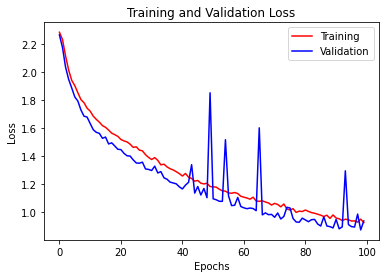

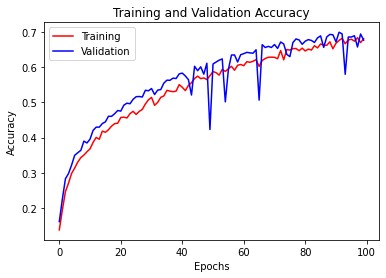

In [50]:
if SAVE_PLOTS:
    matplotlib.use("Agg")

# Plot Loss
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, color="r", label="Training")
plt.plot(range(len(valid_losses)), valid_losses, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Loss")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_D[{}]_loss.png".format(
        LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS, delta))
else:
    plt.show()

# Plot Accuracy
plt.figure()
plt.title("Training and Validation Accuracy")
plt.plot(range(len(train_accuracies)),
         train_accuracies, color="r", label="Training")
plt.plot(range(len(valid_accuracies)), valid_accuracies,
         color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_D[{}]_accuracy.png".format(
        LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS, delta))
else:
    plt.show()
